In [2]:
import pandas as pd
import numpy as np
import scipy.io as sio

In [3]:
from pykalman import KalmanFilter
from scipy.signal import lfilter, cheby1, cheby2, butter

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns
from os import path
import glob
%matplotlib inline
sns.set('notebook')
current_palette = sns.color_palette()

In [5]:
grimm = pd.read_csv('data/alignedGrimmData.csv')
grimm.index = grimm['Unix Time'].values/3600.0
del grimm['Unix Time']

In [6]:
grimm.index

Float64Index([401900.843889, 401900.845556, 401900.847222, 401900.848889,
              401900.850556, 401900.852222, 401900.853889, 401900.855556,
              401900.857222, 401900.858889, 
              ...
              401964.717778, 401964.719722, 401964.721111, 401964.722778,
              401964.724444, 401964.726111, 401964.728056, 401964.729444,
              401964.731111, 401964.733056],
             dtype='float64', length=33314)

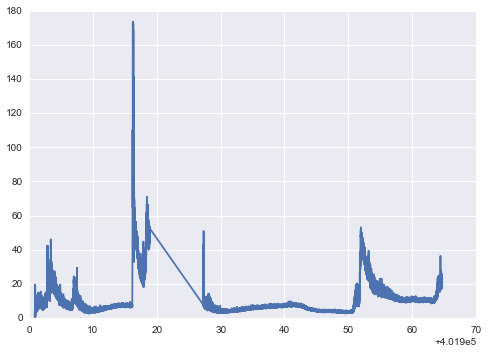

In [7]:
plt.plot(grimm.index, grimm['PM 2.5'])

In [8]:
def load_specks(filename, cov=1075):
    speckdata = sio.loadmat(filename)
    specknames = ['s1']#,'s2','s3']
    specks = []
    for s in specknames:
        speck = pd.DataFrame(speckdata[s], columns=['time','humidity','conc','count','raw','temp'])
        speck.index = pd.to_datetime(speck['time'], unit='s')
        speck.time = speck.time/3600.0
        kf = KalmanFilter(initial_state_mean=0, n_dim_obs=1, transition_matrices=[[1]], observation_matrices=[[1]], observation_covariance=[[cov]], transition_covariance=[[1]])
        speck['kfiltered'] = kf.filter(speck.raw.values)[0]
        b3, a3 = cheby1(2, 0.5, 0.06)
        b4, a4 = butter(1, [0.03, 0.95], btype='bandstop')
        speck['filtered'] = lfilter(b4,a4, lfilter(b3, a3, speck.kfiltered))
        specks.append(speck)
           
    return specks

In [9]:
specks = load_specks('data/alignedGrimmSpeckData.mat')

In [10]:
import plotly.plotly as pypp
import plotly.graph_objs as pygo

In [14]:
cov = 1075
kf = KalmanFilter(initial_state_mean=0, n_dim_obs=1, transition_matrices=[[1]], observation_matrices=[[1]], observation_covariance=[[cov]], transition_covariance=[[1]])
speck = specks[0]
speck['ksmooth'] = kf.smooth(speck.raw.values)[0]

In [15]:
subs=20
speckf = pygo.Scatter(x=speck.time[::subs], y=speck.ksmooth[::subs]/10, opacity=0.5, name='Filtered')
speckc = pygo.Scatter(x=speck.time[::subs], y=speck.conc[::subs], opacity=0.5, name='Concentration')
grimmd = pygo.Scatter(x=grimm.index[::10], y=grimm['PM 2.5'][::10], opacity=0.5, name='GRIMM2.5')

pypp.iplot([grimmd, speckc, speckf])

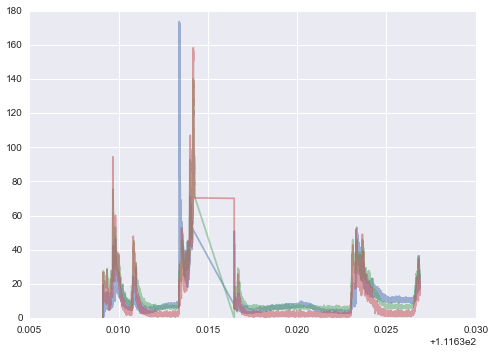

In [16]:
plt.plot(grimm.index/3600.0, grimm['PM 2.5'], alpha=0.5)
for speck in specks:
    plt.plot(speck.time/3600.0, speck.conc, alpha=0.5)
    plt.plot(speck.time/3600.0, speck.filtered/10.0, alpha=0.5)
    

In [17]:
grimm.columns

Index([u'PM 1', u'PM 2.5', u'PM 10', u'0.25', u'0.28', u'0.3', u'0.35', u'0.4',
       u'0.45', u'0.5', u'0.58', u'0.65', u'0.7', u'0.8', u'1', u'1.3', u'1.6',
       u'2', u'2.5', u'3', u'3.5', u'4', u'5', u'6.5', u'7.5', u'8.5', u'10',
       u'12.5', u'15', u'17.5', u'20', u'25', u'30', u'32'],
      dtype='object')

In [29]:
particle_volumes = {x:(float(x)**3)/6 for x in grimm.columns[4:]}


In [53]:
grimm.columns[4:]

Index([u'0.28', u'0.3', u'0.35', u'0.4', u'0.45', u'0.5', u'0.58', u'0.65',
       u'0.7', u'0.8', u'1', u'1.3', u'1.6', u'2', u'2.5', u'3', u'3.5', u'4',
       u'5', u'6.5', u'7.5', u'8.5', u'10', u'12.5', u'15', u'17.5', u'20',
       u'25', u'30', u'32'],
      dtype='object')

In [52]:
print particle_volumes

{'0.8': 0.08533333333333336, '1.6': 0.6826666666666669, '1.3': 0.3661666666666667, '0.3': 0.0045, '0.5': 0.020833333333333332, '0.4': 0.01066666666666667, '0.7': 0.05716666666666665, '6.5': 45.770833333333336, '3.5': 7.145833333333333, '0.65': 0.04577083333333334, '12.5': 325.5208333333333, '7.5': 70.3125, '0.45': 0.015187500000000001, '2.5': 2.6041666666666665, '25': 2604.1666666666665, '0.28': 0.0036586666666666677, '1': 0.16666666666666666, '3': 4.5, '2': 1.3333333333333333, '5': 20.833333333333332, '4': 10.666666666666666, '17.5': 893.2291666666666, '20': 1333.3333333333333, '0.58': 0.03251866666666666, '8.5': 102.35416666666667, '10': 166.66666666666666, '15': 562.5, '32': 5461.333333333333, '0.35': 0.007145833333333331, '30': 4500.0}


In [45]:
grimm_volumes['0.8']/=2

In [46]:
grimm_volumes = grimm.copy()
for x in particle_volumes:
    grimm_volumes[x] *= particle_volumes[x]

In [47]:
grimm_volumes.head()

,PM 1,PM 2.5,PM 10,0.25,0.28,0.3,0.35,0.4,0.45,0.5,...,7.5,8.5,10,12.5,15,17.5,20,25,30,32
401900.843889,0.7,0.7,0.7,1440,1.902507,1.2375,1.143333,0.800000,0.683438,0.625000,...,0.0000,0.000000,0.000000,0.000000,0,0,0,0,0,0
401900.845556,1.0,3.7,7.1,1580,2.579360,1.7100,1.572083,1.173333,1.290938,1.562500,...,0.0000,0.000000,0.000000,0.000000,0,0,0,0,0,0
401900.847222,0.8,0.9,0.9,1365,2.085440,1.3275,1.036146,0.746667,0.531563,0.625000,...,0.0000,0.000000,0.000000,0.000000,0,0,0,0,0,0
401900.848889,0.8,2.7,8.4,1370,2.506187,1.4850,1.036146,0.853333,0.683438,0.833333,...,0.0000,0.000000,0.000000,0.000000,0,0,0,0,0,0
401900.850556,0.8,1.1,6.2,1325,2.122027,1.3275,0.928958,0.640000,0.531563,0.520833,...,70.3125,102.354167,166.666667,325.520833,0,0,0,0,0,0


In [31]:
grimm.head()

,PM 1,PM 2.5,PM 10,0.25,0.28,0.3,0.35,0.4,0.45,0.5,...,7.5,8.5,10,12.5,15,17.5,20,25,30,32
401900.843889,0.7,0.7,0.7,1440,520,275,160,75,45,30,...,0,0,0,0,0,0,0,0,0,0
401900.845556,1.0,3.7,7.1,1580,705,380,220,110,85,75,...,0,0,0,0,0,0,0,0,0,0
401900.847222,0.8,0.9,0.9,1365,570,295,145,70,35,30,...,0,0,0,0,0,0,0,0,0,0
401900.848889,0.8,2.7,8.4,1370,685,330,145,80,45,40,...,0,0,0,0,0,0,0,0,0,0
401900.850556,0.8,1.1,6.2,1325,580,295,130,60,35,25,...,1,1,1,1,0,0,0,0,0,0


In [48]:
import itertools
def group(n, iterable):
    args = [iter(iterable)] * n
    return ([e for e in t if e != None] for t in itertools.izip_longest(*args))

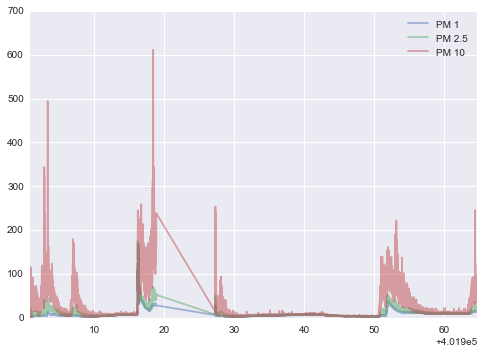

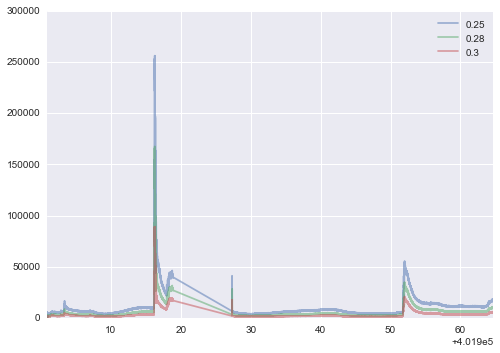

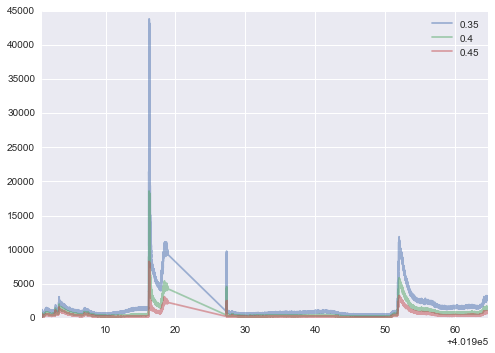

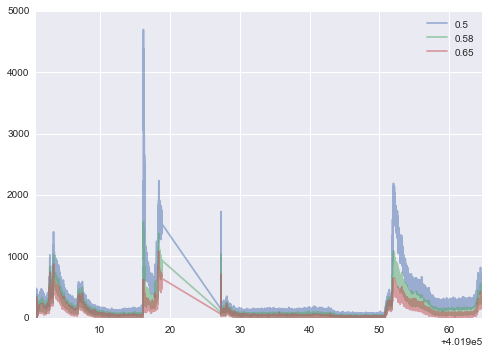

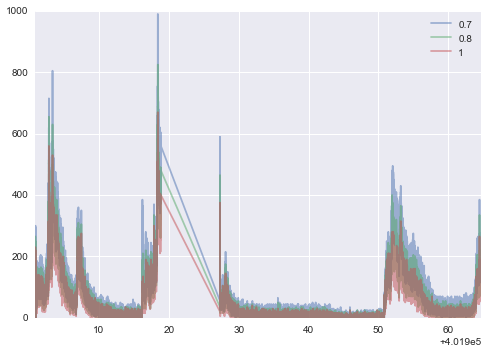

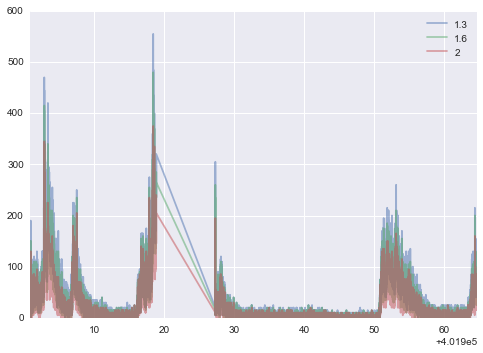

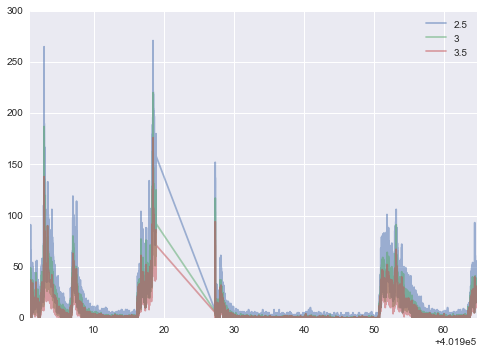

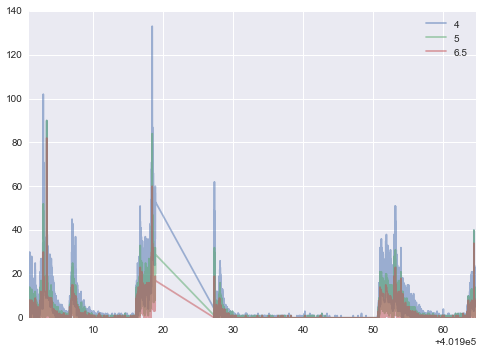

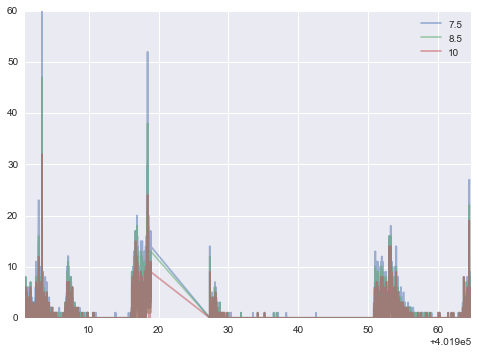

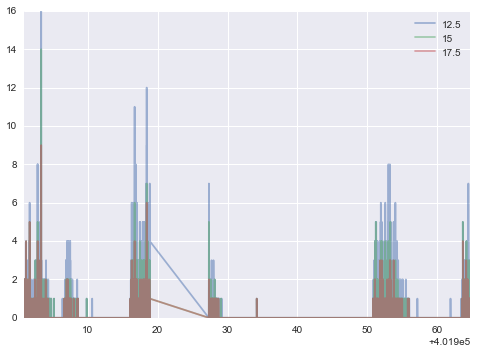

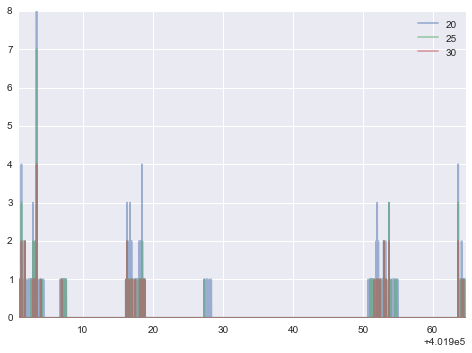

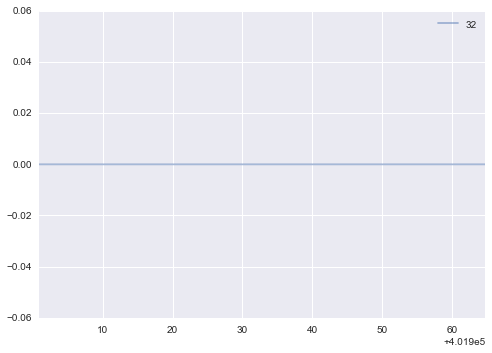

In [51]:
for columns in group(3, grimm.columns):
    grimm[columns].plot(alpha=0.5)

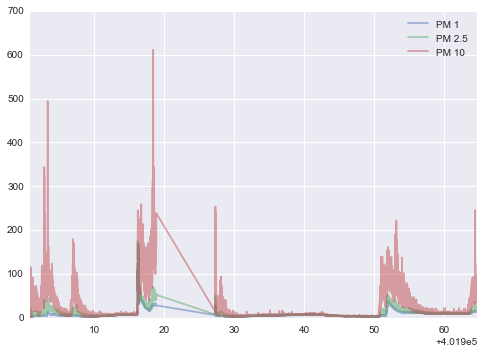

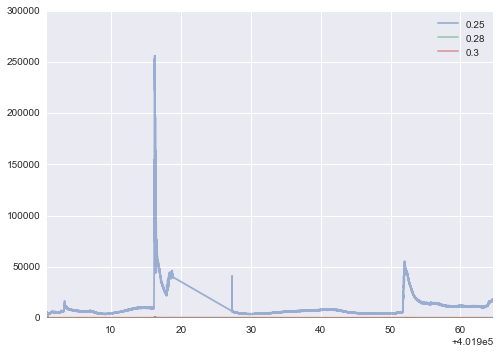

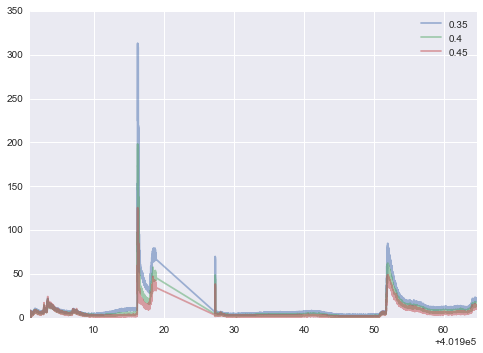

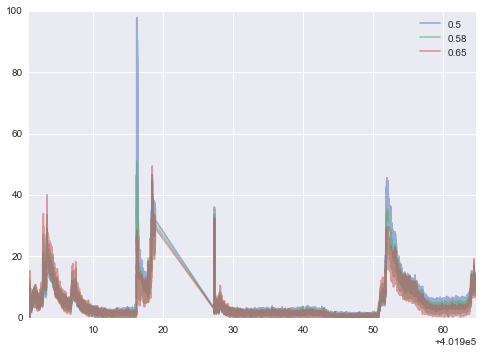

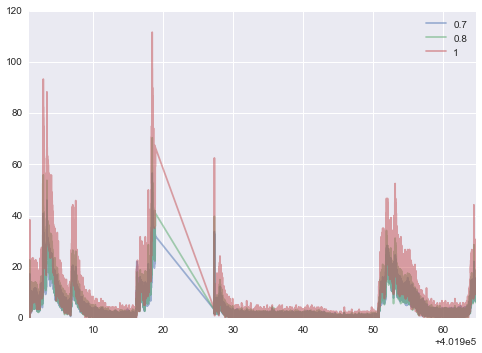

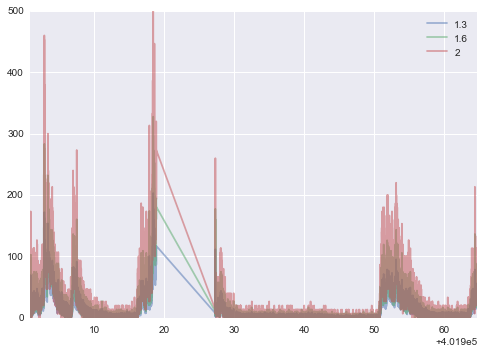

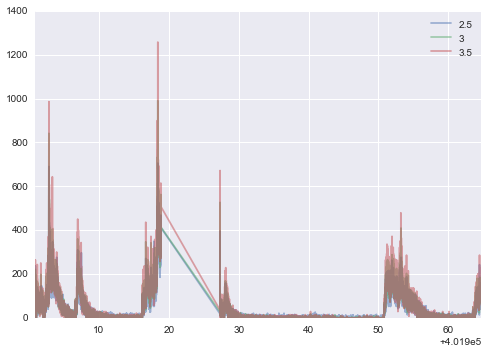

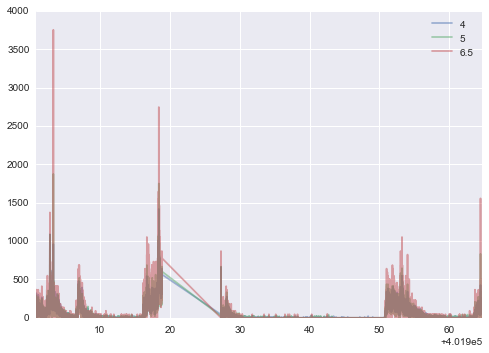

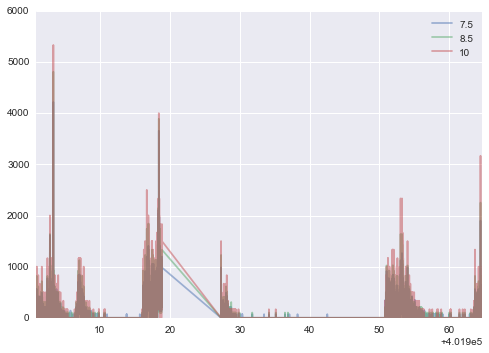

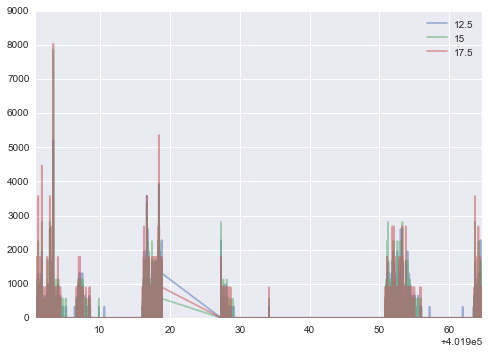

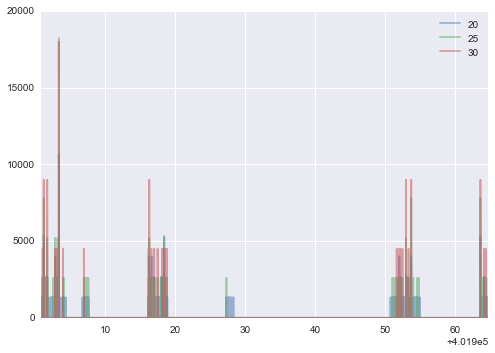

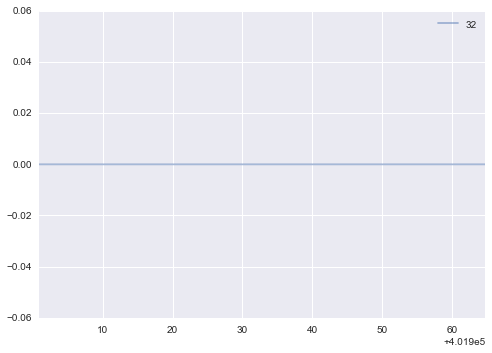

In [50]:
for columns in group(3, grimm.columns):
    grimm_volumes[columns].plot(alpha=0.5)

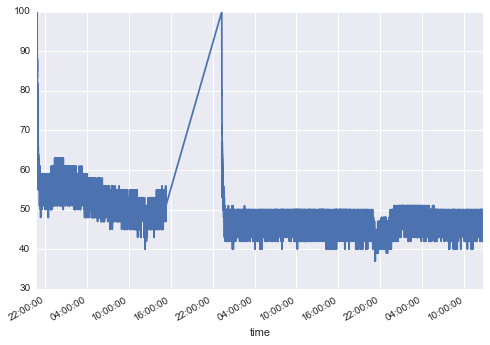

In [19]:
specks[0].humidity.plot()